### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
import random
warnings.filterwarnings(action='ignore')
from scipy.stats import randint
from scipy.stats import uniform
from tqdm import tqdm

from pycaret.classification import *

# 사이킷런
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# 모델
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 선형회귀분석
import statsmodels.api as sm

# optuna 파라미터 튜닝
import optuna
from optuna.samplers import TPESampler

### Data

In [2]:
df = pd.read_csv('./data/train.csv')

In [3]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,244602,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,31,Private,174201,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
3,58,State-gov,110199,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
4,25,State-gov,149248,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43957 entries, 0 to 43956
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              43957 non-null  int64 
 1   workclass        41459 non-null  object
 2   fnlwgt           43957 non-null  int64 
 3   education        43957 non-null  object
 4   educational-num  43957 non-null  int64 
 5   marital-status   43957 non-null  object
 6   occupation       41451 non-null  object
 7   relationship     43957 non-null  object
 8   race             43957 non-null  object
 9   gender           43957 non-null  object
 10  capital-gain     43957 non-null  int64 
 11  capital-loss     43957 non-null  int64 
 12  hours-per-week   43957 non-null  int64 
 13  native-country   43194 non-null  object
 14  income_>50K      43957 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.0+ MB


In [5]:
df.shape

(43957, 15)

### 전처리

In [6]:
new_col = {'income_>50K':'income'}
df = df.rename(columns=new_col)
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,244602,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,31,Private,174201,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
3,58,State-gov,110199,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
4,25,State-gov,149248,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0


In [7]:
#NULL값 처리

df['workclass'] = df['workclass'].fillna('None')
df['occupation'] = df['occupation'].fillna('None')
df['native-country'] = df['native-country'].fillna('Others')
df.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [8]:
df = df[df['native-country'] == 'United-States']
df.drop(columns = ['native-country'], inplace = True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39429 entries, 0 to 43956
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              39429 non-null  int64 
 1   workclass        39429 non-null  object
 2   fnlwgt           39429 non-null  int64 
 3   education        39429 non-null  object
 4   educational-num  39429 non-null  int64 
 5   marital-status   39429 non-null  object
 6   occupation       39429 non-null  object
 7   relationship     39429 non-null  object
 8   race             39429 non-null  object
 9   gender           39429 non-null  object
 10  capital-gain     39429 non-null  int64 
 11  capital-loss     39429 non-null  int64 
 12  hours-per-week   39429 non-null  int64 
 13  income           39429 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 4.5+ MB


In [10]:
# educational-num 편집
print(df.shape)
df = df[df['educational-num'] != 1]
print(df.shape)
df.loc[df['educational-num'].isin([2, 3]), 'educational-num'] = 0
df.loc[df['educational-num'].isin([4, 5]), 'educational-num'] = 1
df.loc[df['educational-num'].isin([6, 7, 8]), 'educational-num'] = 2
for i in range(9, 17):
    df.loc[df['educational-num'].isin([i]), 'educational-num'] = i - 6
print(df['educational-num'].value_counts())

(39429, 14)
(39407, 14)
3     13099
4      9079
7      6468
2      3121
8      2123
5      1702
6      1326
1      1201
9       655
10      432
0       201
Name: educational-num, dtype: int64


In [11]:
df.drop(columns = ['education', 'race', 'gender'], inplace = True)
df.head()

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,capital-gain,capital-loss,hours-per-week,income
0,67,Private,366425,10,Divorced,Exec-managerial,Not-in-family,99999,0,60,1
1,17,Private,244602,2,Never-married,Other-service,Own-child,0,0,15,0
2,31,Private,174201,7,Married-civ-spouse,Exec-managerial,Husband,0,0,40,1
3,58,State-gov,110199,1,Married-civ-spouse,Transport-moving,Husband,0,0,40,0
4,25,State-gov,149248,4,Never-married,Other-service,Not-in-family,0,0,40,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39407 entries, 0 to 43956
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              39407 non-null  int64 
 1   workclass        39407 non-null  object
 2   fnlwgt           39407 non-null  int64 
 3   educational-num  39407 non-null  int64 
 4   marital-status   39407 non-null  object
 5   occupation       39407 non-null  object
 6   relationship     39407 non-null  object
 7   capital-gain     39407 non-null  int64 
 8   capital-loss     39407 non-null  int64 
 9   hours-per-week   39407 non-null  int64 
 10  income           39407 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 3.6+ MB


#### 범주형 변수 처리

In [13]:
df = pd.get_dummies(df)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39407 entries, 0 to 43956
Data columns (total 44 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   age                                   39407 non-null  int64
 1   fnlwgt                                39407 non-null  int64
 2   educational-num                       39407 non-null  int64
 3   capital-gain                          39407 non-null  int64
 4   capital-loss                          39407 non-null  int64
 5   hours-per-week                        39407 non-null  int64
 6   income                                39407 non-null  int64
 7   workclass_Federal-gov                 39407 non-null  uint8
 8   workclass_Local-gov                   39407 non-null  uint8
 9   workclass_Never-worked                39407 non-null  uint8
 10  workclass_None                        39407 non-null  uint8
 11  workclass_Private                     394

### OLS 회귀분석

In [15]:
X = df.drop(columns = ['educational-num'])
y = df[['educational-num']]

# for b0, 상수항 추가
# x_data = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y.astype(float), X.astype(float))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        educational-num   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     705.4
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:51:42   Log-Likelihood:                -73957.
No. Observations:               39407   AIC:                         1.480e+05
Df Residuals:                   39368   BIC:                         1.483e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
age                                     -0.0028      0.001     -3.730      0.000      -0.004      -0.001
fnlwgt                               -1.581e-07    7.6e-08     -2.081      0.037   -3.07e-07    -9.2e-09
capital-gain                          1.211e-05   1.09e-06     11.140      0.000    9.98e-06    1.42e-05
capital-loss                             0.0001   1.98e-05      6.228      0.000    8.47e-05       0.000
hours-per-week                           0.0089      0.001     12.514      0.000       0.008       0.010
income                                   0.9331      0.023     40.952      0.000       0.888       0.978
workclass_Federal-gov                    0.8889      0.060     14.734      0.000       0.771       1.007
workclass_Local-gov                      1.0743      0.053     20.272      0.000       0.970       1.178
workclass_Never-worked                  -0.4670      0.366     -1.276      0.202      -1.184       0.250
workclass_None                           0.8191      0.196      4.190      0.000       0.436       1.202
workclass_Private                        0.7553      0.045     16.729      0.000       0.667       0.844
workclass_Self-emp-inc                   0.9126      0.060     15.132      0.000       0.794       1.031
workclass_Self-emp-not-inc               0.9265      0.052     17.807      0.000       0.824       1.028
workclass_State-gov                      1.2157      0.057     21.431      0.000       1.105       1.327
workclass_Without-pay                    0.7643      0.329      2.326      0.020       0.120       1.408
marital-status_Divorced                  1.0698      0.055     19.395      0.000       0.962       1.178
marital-status_Married-AF-spouse         0.7920      0.270      2.937      0.003       0.263       1.321
marital-status_Married-civ-spouse        0.9539      0.084     11.397      0.000       0.790       1.118
marital-status_Married-spouse-absent     1.2516      0.090     13.970      0.000       1.076       1.427
marital-status_Never-married             1.3226      0.051     25.800      0.000       1.222       1.423
marital-status_Separated                 0.8279      0.066     12.614      0.000       0.699       0.957
marital-status_Widowed                   0.6720      0.068      9.881      0.000       0.539       0.805
occupation_Adm-clerical                  0.6560      0.040     16.560      0.000       0.578       0.734
occupation_Armed-Forces                  0.6857      0.431      1.589      0.112      -0.160       1.531
occupation_Craft-repair                 -0.1683      0.039     -4.262      0.000      -0.246      -0.091
occupation_Exec-managerial               1.5597      0.040     39.277      0.000       1.482       1.638
occupation_Farming-fishing            

In [16]:
drop_occupation = [f'occupation_{occupation}' for occupation in ['Other-service']]
df = df[(df['occupation_Other-service'] == 0)]

X = df.drop(columns = ['educational-num'] + drop_occupation)
y = df[['educational-num']]


# OLS 검정
multi_model = sm.OLS(y.astype(float), X.astype(float))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        educational-num   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     655.6
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:51:42   Log-Likelihood:                -67317.
No. Observations:               35617   AIC:                         1.347e+05
Df Residuals:                   35579   BIC:                         1.350e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
age                                     -0.0020      0.001     -2.450      0.014      -0.004      -0.000
fnlwgt                               -1.618e-07   8.15e-08     -1.986      0.047   -3.22e-07    -2.1e-09
capital-gain                          1.215e-05   1.11e-06     10.935      0.000    9.97e-06    1.43e-05
capital-loss                             0.0001   2.06e-05      6.328      0.000       9e-05       0.000
hours-per-week                           0.0094      0.001     12.326      0.000       0.008       0.011
income                                   0.9321      0.023     39.689      0.000       0.886       0.978
workclass_Federal-gov                    0.8748      0.063     13.945      0.000       0.752       0.998
workclass_Local-gov                      1.1065      0.056     19.839      0.000       0.997       1.216
workclass_Never-worked                  -0.4690      0.371     -1.265      0.206      -1.196       0.258
workclass_None                           0.8082      0.198      4.076      0.000       0.420       1.197
workclass_Private                        0.7298      0.047     15.415      0.000       0.637       0.823
workclass_Self-emp-inc                   0.8813      0.063     14.073      0.000       0.759       1.004
workclass_Self-emp-not-inc               0.8946      0.055     16.388      0.000       0.788       1.002
workclass_State-gov                      1.2433      0.060     20.781      0.000       1.126       1.361
workclass_Without-pay                    0.7400      0.342      2.164      0.030       0.070       1.410
marital-status_Divorced                  1.0349      0.060     17.325      0.000       0.918       1.152
marital-status_Married-AF-spouse         0.7898      0.294      2.687      0.007       0.214       1.366
marital-status_Married-civ-spouse        0.9439      0.090     10.457      0.000       0.767       1.121
marital-status_Married-spouse-absent     1.2724      0.097     13.094      0.000       1.082       1.463
marital-status_Never-married             1.3176      0.056     23.682      0.000       1.209       1.427
marital-status_Separated                 0.8086      0.072     11.239      0.000       0.668       0.950
marital-status_Widowed                   0.6423      0.074      8.673      0.000       0.497       0.787
occupation_Adm-clerical                  0.6500      0.042     15.460      0.000       0.568       0.732
occupation_Armed-Forces                  0.6712      0.436      1.541      0.123      -0.183       1.525
occupation_Craft-repair                 -0.1698      0.042     -4.052      0.000      -0.252      -0.088
occupation_Exec-managerial               1.5513      0.042     36.798      0.000       1.469       1.634
occupation_Farming-fishing            

In [17]:
drop_occupation = [f'occupation_{occupation}' for occupation in ['Armed-Forces', 'Other-service']]
df = df[(df['occupation_Armed-Forces'] == 0) & (df['occupation_Other-service'] == 0)]

X = df.drop(columns = ['educational-num'] + drop_occupation)
y = df[['educational-num']]


# OLS 검정
multi_model = sm.OLS(y.astype(float), X.astype(float))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        educational-num   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     673.8
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:51:42   Log-Likelihood:                -67292.
No. Observations:               35605   AIC:                         1.347e+05
Df Residuals:                   35568   BIC:                         1.350e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
age                                     -0.0020      0.001     -2.461      0.014      -0.004      -0.000
fnlwgt                               -1.628e-07   8.15e-08     -1.998      0.046   -3.23e-07    -3.1e-09
capital-gain                          1.215e-05   1.11e-06     10.933      0.000    9.97e-06    1.43e-05
capital-loss                             0.0001   2.06e-05      6.334      0.000    9.02e-05       0.000
hours-per-week                           0.0094      0.001     12.338      0.000       0.008       0.011
income                                   0.9312      0.023     39.649      0.000       0.885       0.977
workclass_Federal-gov                    0.8584      0.063     13.713      0.000       0.736       0.981
workclass_Local-gov                      1.0900      0.055     19.936      0.000       0.983       1.197
workclass_Never-worked                  -0.4593      0.371     -1.239      0.215      -1.186       0.267
workclass_None                           0.8182      0.198      4.127      0.000       0.430       1.207
workclass_Private                        0.7133      0.046     15.492      0.000       0.623       0.804
workclass_Self-emp-inc                   0.8651      0.062     14.037      0.000       0.744       0.986
workclass_Self-emp-not-inc               0.8781      0.053     16.431      0.000       0.773       0.983
workclass_State-gov                      1.2268      0.059     20.861      0.000       1.112       1.342
workclass_Without-pay                    0.7231      0.342      2.117      0.034       0.054       1.393
marital-status_Divorced                  1.0202      0.059     17.275      0.000       0.904       1.136
marital-status_Married-AF-spouse         0.7784      0.294      2.651      0.008       0.203       1.354
marital-status_Married-civ-spouse        0.9327      0.090     10.344      0.000       0.756       1.109
marital-status_Married-spouse-absent     1.2578      0.097     13.003      0.000       1.068       1.447
marital-status_Never-married             1.3030      0.055     23.700      0.000       1.195       1.411
marital-status_Separated                 0.7939      0.071     11.123      0.000       0.654       0.934
marital-status_Widowed                   0.6279      0.073      8.542      0.000       0.484       0.772
occupation_Adm-clerical                  0.6962      0.030     22.880      0.000       0.637       0.756
occupation_Craft-repair                 -0.1234      0.030     -4.129      0.000      -0.182      -0.065
occupation_Exec-managerial               1.5979      0.030     52.571      0.000       1.538       1.657
occupation_Farming-fishing              -0.1159      0.050     -2.324      0.020      -0.214      -0.018
occupation_Handlers-cleaners          

In [18]:
drop_occupation = [f'occupation_{occupation}' for occupation in ['Armed-Forces', 'Other-service', 'Priv-house-serv']]
df = df[(df['occupation_Armed-Forces'] == 0) & (df['occupation_Other-service'] == 0) & (df['occupation_Priv-house-serv'] == 0)]

X = df.drop(columns = ['educational-num'] + drop_occupation)
y = df[['educational-num']]

# OLS 검정
multi_model = sm.OLS(y.astype(float), X.astype(float))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        educational-num   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     688.0
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:51:43   Log-Likelihood:                -67037.
No. Observations:               35464   AIC:                         1.341e+05
Df Residuals:                   35428   BIC:                         1.345e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
age                                     -0.0019      0.001     -2.369      0.018      -0.003      -0.000
fnlwgt                               -1.527e-07   8.17e-08     -1.870      0.061   -3.13e-07    7.31e-09
capital-gain                          1.212e-05   1.11e-06     10.908      0.000    9.95e-06    1.43e-05
capital-loss                             0.0001   2.06e-05      6.365      0.000    9.09e-05       0.000
hours-per-week                           0.0094      0.001     12.188      0.000       0.008       0.011
income                                   0.9299      0.024     39.564      0.000       0.884       0.976
workclass_Federal-gov                    0.8649      0.063     13.821      0.000       0.742       0.988
workclass_Local-gov                      1.0963      0.055     20.069      0.000       0.989       1.203
workclass_Never-worked                  -0.4634      0.371     -1.250      0.211      -1.190       0.263
workclass_None                           0.8137      0.198      4.099      0.000       0.425       1.203
workclass_Private                        0.7197      0.046     15.615      0.000       0.629       0.810
workclass_Self-emp-inc                   0.8717      0.062     14.146      0.000       0.751       0.992
workclass_Self-emp-not-inc               0.8843      0.053     16.556      0.000       0.780       0.989
workclass_State-gov                      1.2331      0.059     20.981      0.000       1.118       1.348
workclass_Without-pay                    0.7297      0.341      2.138      0.033       0.061       1.399
marital-status_Divorced                  1.0295      0.059     17.369      0.000       0.913       1.146
marital-status_Married-AF-spouse         0.7694      0.294      2.618      0.009       0.193       1.345
marital-status_Married-civ-spouse        0.9228      0.091     10.136      0.000       0.744       1.101
marital-status_Married-spouse-absent     1.2689      0.097     13.093      0.000       1.079       1.459
marital-status_Never-married             1.3121      0.055     23.779      0.000       1.204       1.420
marital-status_Separated                 0.8043      0.072     11.222      0.000       0.664       0.945
marital-status_Widowed                   0.6429      0.074      8.672      0.000       0.498       0.788
occupation_Adm-clerical                  0.6780      0.030     22.690      0.000       0.619       0.737
occupation_Craft-repair                 -0.1415      0.029     -4.851      0.000      -0.199      -0.084
occupation_Exec-managerial               1.5800      0.030     53.159      0.000       1.522       1.638
occupation_Farming-fishing              -0.1339      0.049     -2.719      0.007      -0.230      -0.037
occupation_Handlers-cleaners          

In [19]:
drop_workclass = [f'workclass_{status}' for status in ['Never-worked']]
df = df[(df['workclass_Never-worked'] == 0)]

X = df.drop(columns = ['educational-num'] + drop_occupation + drop_workclass)
y = df[['educational-num']]


# OLS 검정
multi_model = sm.OLS(y.astype(float), X.astype(float))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        educational-num   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     707.7
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:51:43   Log-Likelihood:                -67025.
No. Observations:               35456   AIC:                         1.341e+05
Df Residuals:                   35421   BIC:                         1.344e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
age                                     -0.0019      0.001     -2.375      0.018      -0.004      -0.000
fnlwgt                                -1.54e-07   8.17e-08     -1.886      0.059   -3.14e-07    6.05e-09
capital-gain                          1.212e-05   1.11e-06     10.907      0.000    9.95e-06    1.43e-05
capital-loss                             0.0001   2.06e-05      6.365      0.000    9.09e-05       0.000
hours-per-week                           0.0093      0.001     12.179      0.000       0.008       0.011
income                                   0.9300      0.024     39.564      0.000       0.884       0.976
workclass_Federal-gov                    0.8472      0.061     13.840      0.000       0.727       0.967
workclass_Local-gov                      1.0786      0.053     20.315      0.000       0.975       1.183
workclass_None                           0.5676      0.025     22.286      0.000       0.518       0.617
workclass_Private                        0.7021      0.044     15.850      0.000       0.615       0.789
workclass_Self-emp-inc                   0.8540      0.060     14.175      0.000       0.736       0.972
workclass_Self-emp-not-inc               0.8666      0.052     16.718      0.000       0.765       0.968
workclass_State-gov                      1.2154      0.057     21.199      0.000       1.103       1.328
workclass_Without-pay                    0.7122      0.341      2.090      0.037       0.044       1.380
marital-status_Divorced                  1.0433      0.058     17.840      0.000       0.929       1.158
marital-status_Married-AF-spouse         0.7835      0.294      2.669      0.008       0.208       1.359
marital-status_Married-civ-spouse        0.9368      0.090     10.352      0.000       0.759       1.114
marital-status_Married-spouse-absent     1.2802      0.097     13.242      0.000       1.091       1.470
marital-status_Never-married             1.3256      0.054     24.407      0.000       1.219       1.432
marital-status_Separated                 0.8179      0.071     11.524      0.000       0.679       0.957
marital-status_Widowed                   0.6564      0.073      8.934      0.000       0.512       0.800
occupation_Adm-clerical                  0.6668      0.028     23.415      0.000       0.611       0.723
occupation_Craft-repair                 -0.1528      0.028     -5.511      0.000      -0.207      -0.098
occupation_Exec-managerial               1.5688      0.028     55.438      0.000       1.513       1.624
occupation_Farming-fishing              -0.1451      0.048     -2.997      0.003      -0.240      -0.050
occupation_Handlers-cleaners            -0.2465      0.041     -6.021      0.000      -0.327      -0.166
occupation_Machine-op-inspct          

In [20]:
X = df.drop(columns = ['educational-num', 'fnlwgt'] + drop_occupation + drop_workclass)
y = df[['educational-num']]


# OLS 검정
multi_model = sm.OLS(y.astype(float), X.astype(float))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        educational-num   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     729.0
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:51:43   Log-Likelihood:                -67027.
No. Observations:               35456   AIC:                         1.341e+05
Df Residuals:                   35422   BIC:                         1.344e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
age                                     -0.0018      0.001     -2.286      0.022      -0.003      -0.000
capital-gain                          1.212e-05   1.11e-06     10.899      0.000    9.94e-06    1.43e-05
capital-loss                             0.0001   2.06e-05      6.369      0.000     9.1e-05       0.000
hours-per-week                           0.0094      0.001     12.204      0.000       0.008       0.011
income                                   0.9288      0.023     39.527      0.000       0.883       0.975
workclass_Federal-gov                    0.8396      0.061     13.745      0.000       0.720       0.959
workclass_Local-gov                      1.0703      0.053     20.227      0.000       0.967       1.174
workclass_None                           0.5611      0.025     22.234      0.000       0.512       0.611
workclass_Private                        0.6936      0.044     15.739      0.000       0.607       0.780
workclass_Self-emp-inc                   0.8467      0.060     14.082      0.000       0.729       0.965
workclass_Self-emp-not-inc               0.8595      0.052     16.625      0.000       0.758       0.961
workclass_State-gov                      1.2082      0.057     21.119      0.000       1.096       1.320
workclass_Without-pay                    0.7032      0.341      2.064      0.039       0.035       1.371
marital-status_Divorced                  1.0351      0.058     17.748      0.000       0.921       1.149
marital-status_Married-AF-spouse         0.7745      0.294      2.639      0.008       0.199       1.350
marital-status_Married-civ-spouse        0.9279      0.090     10.267      0.000       0.751       1.105
marital-status_Married-spouse-absent     1.2721      0.097     13.171      0.000       1.083       1.461
marital-status_Never-married             1.3168      0.054     24.334      0.000       1.211       1.423
marital-status_Separated                 0.8068      0.071     11.406      0.000       0.668       0.945
marital-status_Widowed                   0.6490      0.073      8.845      0.000       0.505       0.793
occupation_Adm-clerical                  0.6613      0.028     23.343      0.000       0.606       0.717
occupation_Craft-repair                 -0.1582      0.028     -5.737      0.000      -0.212      -0.104
occupation_Exec-managerial               1.5639      0.028     55.494      0.000       1.509       1.619
occupation_Farming-fishing              -0.1470      0.048     -3.037      0.002      -0.242      -0.052
occupation_Handlers-cleaners            -0.2518      0.041     -6.167      0.000      -0.332      -0.172
occupation_Machine-op-inspct            -0.3006      0.036     -8.354      0.000      -0.371      -0.230
occupation_None                       

In [21]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

### pycaret

In [22]:
train = pd.concat([X_train, y_train], axis = 1)
train

,age,capital-gain,capital-loss,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,workclass_None,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_None,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,educational-num
2330,37,0,0,40,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3
42464,44,0,0,40,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,10
10669,44,0,0,48,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,7
9194,45,0,0,25,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2
8084,59,0,1579,60,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7333,29,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,2
43644,33,0,0,35,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,7
9906,78,0,0,36,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
10331,20,0,0,10,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,4


In [23]:
# 환경 설정
clf = setup(data = train, target = 'educational-num', session_id = 123, silent = True, use_gpu = True)

,Description,Value
0,session_id,123
1,Target,educational-num
2,Target Type,Multiclass
3,Label Encoded,"0: 0, 1: 1, 10: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10"
4,Original Data,"(35101, 39)"
5,Missing Values,False
6,Numeric Features,37
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [24]:
# 모델들의 평가 지표 점수 출력(F1 기준 정렬)
compare_models(sort = 'F1', n_select = 1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.4402,0.7395,0.2251,0.4089,0.3929,0.2515,0.2632,16.8020
lightgbm,Light Gradient Boosting Machine,0.4381,0.7368,0.2254,0.4130,0.3877,0.2469,0.2614,1.6420
gbc,Gradient Boosting Classifier,0.4439,0.7428,0.2253,0.4213,0.3875,0.2505,0.2693,24.7120
xgboost,Extreme Gradient Boosting,0.4331,0.7337,0.2216,0.3996,0.3846,0.2407,0.2533,9.8720
lda,Linear Discriminant Analysis,0.4033,0.7183,0.2376,0.3675,0.3666,0.2175,0.2226,0.1330
ada,Ada Boost Classifier,0.4108,0.6209,0.2020,0.3791,0.3644,0.2174,0.2268,0.8480
rf,Random Forest Classifier,0.3582,0.6741,0.2078,0.3369,0.3448,0.1754,0.1762,4.5650
ridge,Ridge Classifier,0.4170,0.0000,0.1544,0.3345,0.3373,0.2061,0.2217,0.0370
et,Extra Trees Classifier,0.3434,0.6402,0.2041,0.3270,0.3334,0.1614,0.1619,6.0540
knn,K Neighbors Classifier,0.3401,0.6186,0.1609,0.3060,0.3155,0.1370,0.1393,1.7230


#### Train test 데이터 분리

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y, 
                                                  test_size=0.01, 
                                                  random_state=42,
                                                  stratify = y)

### 모델 성능 비교

In [26]:
xgb = XGBClassifier(objective = 'multi:softprob')
lgb = LGBMClassifier()
cat = CatBoostClassifier(silent = True)


# XGBoostClassifier 학습,예측,정확도 출력
xgb.fit(X_train, y_train, eval_metric = 'mlogloss')
xgb_pred = xgb.predict(X_test)
print('XGBoostClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, xgb_pred)))

# LightGBMBoostClassifier 학습,예측,정확도 출력
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)
print('LightGBMBoostClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, lgb_pred)))

# CatBoostClassifier 학습,예측,정확도 출력
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_test)
print('CatBoostClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, cat_pred)))

XGBoostClassifier 정확도: 0.4817
LightGBMBoostClassifier 정확도: 0.4732
CatBoostClassifier 정확도: 0.4676


In [27]:
xgb = XGBClassifier(objective = 'multi:softprob')
lgb = LGBMClassifier()
cat = CatBoostClassifier(silent = True)


# XGBoostClassifier 학습,예측,정확도 출력
xgb.fit(X_train, y_train, eval_metric = 'mlogloss')
xgb_pred = xgb.predict(X_test)
print('XGBoostClassifier 정확도: {0:.4f}'.format(f1_score(y_test, xgb_pred, average='micro')))

# LightGBMBoostClassifier 학습,예측,정확도 출력
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)
print('LightGBMBoostClassifier 정확도: {0:.4f}'.format(f1_score(y_test, lgb_pred, average='micro')))

# LightGBMBoostClassifier 학습,예측,정확도 출력
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_test)
print('CatBoostClassifier 정확도: {0:.4f}'.format(f1_score(y_test, cat_pred, average='micro')))

XGBoostClassifier 정확도: 0.4817
LightGBMBoostClassifier 정확도: 0.4732
CatBoostClassifier 정확도: 0.4676


### 파라미터 튜닝

#### Catboost

In [25]:
def objective(trial):
#     param = {
#       "random_state": 42,
#       'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#       'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
#       "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
#       "max_depth":trial.suggest_int("max_depth", 4, 16),
#       'random_strength' :trial.suggest_int('random_strength', 0, 100),
#       "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
#       "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
#       "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#       "max_bin": trial.suggest_int("max_bin", 200, 500),
#       'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
#     }
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y, 
                                                  test_size=0.01, 
                                                  random_state=42,
                                                  stratify = y)
    param = {
      "random_state": 42,
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
      "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 16),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
    }
    
    cat = CatBoostClassifier(**param)
    cat.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          early_stopping_rounds=35,
          verbose=100)
    cat_pred = cat.predict(X_test)
    accuracy = accuracy_score(y_test, cat_pred)

    return accuracy

In [ ]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'maximize',
    sampler = sampler,
)
study.optimize(objective, n_trials = 10)
print("Best Score:",study.best_value)
print("Best trial", study.best_trial.params)

#### best 파라미터 활용 학습

In [23]:
param = {'random_state': 42, 'learning_rate': 0.018659959624904916, 'n_estimators': 3738, 
         'max_depth': 10, 'l2_leaf_reg': 1.2964031109077052e-05, 'random_strength': 29}

X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y, 
                                                  test_size=0.01, 
                                                  random_state=42,
                                                  stratify = y)

cat = CatBoostClassifier(**param)
cat.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=35,
        verbose=100)

cat_pred = cat.predict(X_test) 
print(f'CatBoostClassifier 정확도 : ', accuracy_score(y_test, cat_pred))

0:	learn: 2.3692126	test: 2.3692126	test1: 2.3693904	best: 2.3693904 (0)	total: 230ms	remaining: 14m 20s
100:	learn: 1.6677635	test: 1.6677635	test1: 1.6997109	best: 1.6997109 (100)	total: 8.69s	remaining: 5m 12s
200:	learn: 1.5644543	test: 1.5644543	test1: 1.6158797	best: 1.6158787 (199)	total: 16.5s	remaining: 4m 50s
300:	learn: 1.5121873	test: 1.5121873	test1: 1.5856547	best: 1.5856547 (300)	total: 25.2s	remaining: 4m 47s
400:	learn: 1.4751490	test: 1.4751490	test1: 1.5657094	best: 1.5657094 (400)	total: 33.8s	remaining: 4m 41s
500:	learn: 1.4488069	test: 1.4488069	test1: 1.5534276	best: 1.5534276 (500)	total: 41.6s	remaining: 4m 28s
600:	learn: 1.4236337	test: 1.4236337	test1: 1.5434614	best: 1.5434614 (600)	total: 49.5s	remaining: 4m 18s
700:	learn: 1.3936462	test: 1.3936462	test1: 1.5341553	best: 1.5340142 (695)	total: 59s	remaining: 4m 15s
800:	learn: 1.3498054	test: 1.3498054	test1: 1.5232376	best: 1.5231589 (799)	total: 1m 11s	remaining: 4m 21s
Stopped by overfitting detector 

#### feature importance

In [24]:
def plot_feature_importance(importance, names, model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending= False, inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' feature importance')
    plt.xlabel('feature importance')
    plt.ylabel('feature names')

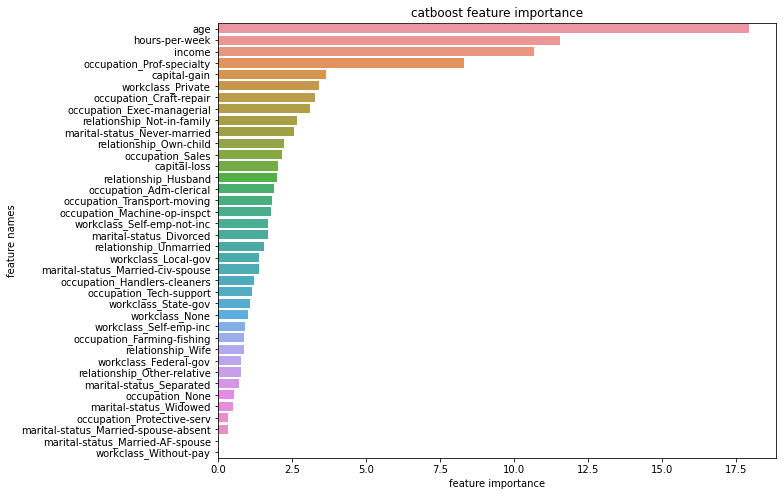

In [25]:
plot_feature_importance(cat.get_feature_importance(), X_train.columns, 'catboost')

In [26]:
 X_train.columns

Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'income',
       'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_None',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_None', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'relationship_Husband', 'relationship_Not-in-family',
       'relationship_Ot

In [27]:
cat.get_feature_importance()

array([17.95913807,  3.64528461,  2.01757625, 11.5606266 , 10.67851688,
        0.79411714,  1.40273643,  1.01344591,  3.4266205 ,  0.91146699,
        1.6869141 ,  1.08161394,  0.02419708,  1.68328508,  0.02472063,
        1.39333892,  0.33591652,  2.58578811,  0.69927403,  0.49703791,
        1.88026772,  3.27013795,  3.12655914,  0.87694323,  1.21499929,
        1.79271146,  0.53973268,  8.32507285,  0.33814478,  2.16106688,
        1.14581073,  1.82377669,  1.99200125,  2.68486492,  0.77630305,
        2.22399972,  1.5394866 ,  0.86650534])

#### Lightgbm

In [ ]:
lgb = LGBMClassifier()

params = {'boosting_type' : ['gbdt', 'dart', 'goss', 'rf'],
          'num_leaves': randint(6, 127), 
          'min_child_samples': randint(10, 100), 
          'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
          'subsample': uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': uniform(loc=0.4, scale=0.6),
          'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
          'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
          'learning_rate': uniform(loc = 0.001, scale = 0.5),
          'objective': ['multiclass'],
          'random_state' : randint(0, 100),
          'n_estimators' : randint(100, 1000)
          }

X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y, 
                                                  test_size=0.01, 
                                                  random_state=42,
                                                  stratify = y)

param_dict = {} # 파라미터 저장
acc_dict = {} # randomstate 별 정확도 저장
# random search
for i in tqdm(range(5)):
    clf = RandomizedSearchCV(estimator = lgb, param_distributions = params, scoring='accuracy', random_state = i, n_jobs = -1, verbose=True, cv=5)
    clf.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="logloss", eval_set=[(X_train, y_train), (X_test, y_test)])
    preds = clf.predict(X_test)
    param_dict[i] = clf.best_params_
    acc_dict[i] = accuracy_score(y_test, preds)
    print('LightGBMBoostClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, preds)))

In [29]:
# acc 가장 큰  random_state index

[k for k,v in acc_dict.items() if max(acc_dict.values()) == v]

[2]

In [30]:
# 최대 값일 때 파라미터

param_dict[2]

{'boosting_type': 'dart',
 'colsample_bytree': 0.4719703255578339,
 'learning_rate': 0.2435879547999325,
 'min_child_samples': 30,
 'min_child_weight': 1,
 'n_estimators': 905,
 'num_leaves': 45,
 'objective': 'multiclass',
 'random_state': 67,
 'reg_alpha': 10,
 'reg_lambda': 10,
 'subsample': 0.6694375824000827}

#### Best 파라미터 활용 학습 

In [ ]:
params = {'boosting_type': 'dart',
 'colsample_bytree': 0.4719703255578339,
 'learning_rate': 0.2435879547999325,
 'min_child_samples': 30,
 'min_child_weight': 1,
 'n_estimators': 905,
 'num_leaves': 45,
 'objective': 'multiclass',
 'random_state': 67,
 'reg_alpha': 10,
 'reg_lambda': 10,
 'subsample': 0.6694375824000827}

X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y, 
                                                  test_size=0.01, 
                                                  random_state=42,
                                                  stratify = y)

lgb = LGBMClassifier(**params)
lgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=30,
        eval_metric = 'logloss',
        verbose=True)

lgb_pred = lgb.predict(X_test) 
print(f'LightGBMBoostClassifier 정확도 : ', accuracy_score(y_test, lgb_pred))

In [33]:
# LightGBM 정확도
print(f'LightGBMBoostClassifier 정확도 : ', accuracy_score(y_test, lgb_pred))

LightGBMBoostClassifier 정확도 :  0.4788732394366197


#### feature importance

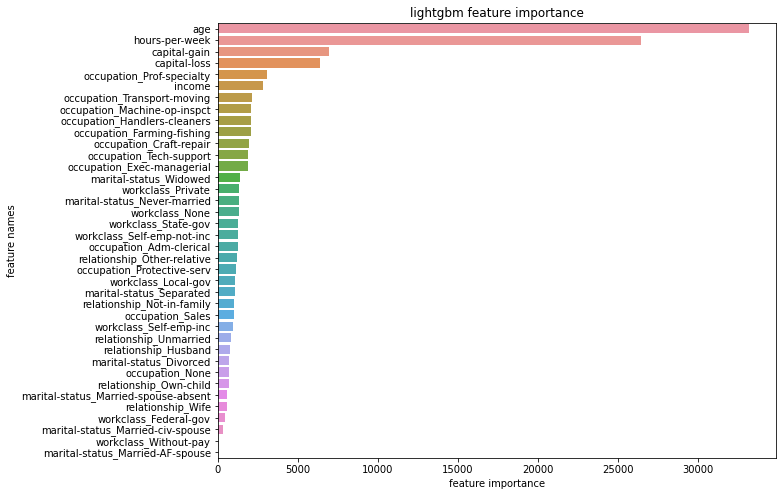

In [34]:
plot_feature_importance(lgb.feature_importances_, X_train.columns, 'lightgbm')

In [43]:
 X_train.columns

Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'income',
       'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_None',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_None', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'relationship_Husband', 'relationship_Not-in-family',
       'relationship_Ot

In [44]:
lgb.feature_importances_

array([33204,  6932,  6386, 26424,  2793,   423,  1066,  1302,  1340,
         933,  1277,  1280,     0,   717,     0,   337,   596,  1313,
        1062,  1350,  1277,  1964,  1853,  2041,  2059,  2082,   701,
        3041,  1113,  1009,  1876,  2112,   738,  1024,  1166,   663,
         815,   571])

### XGBOOST

In [ ]:
xgb = XGBClassifier(silent = True, nthread = 1)

# A parameter grid for XGBoost
params = {
        'learning_rate': uniform(loc = 0.001, scale = 0.5),
        'n_estimators' : randint(100, 1000),
        'random_state' : randint(0, 100),
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'objective' : 'multi:softprob'
        }

X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y, 
                                                  test_size=0.01, 
                                                  random_state=42,
                                                  stratify = y)

param_dict = {} # 파라미터 저장
acc_dict = {} # randomstate 별 정확도 저장
# random search
for i in tqdm(range(5)):
    clf = RandomizedSearchCV(estimator = xgb, param_distributions = params, scoring='accuracy', random_state = i, n_jobs = -1, verbose=True, cv=5)
    clf.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="mlogloss", eval_set=[(X_train, y_train), (X_test, y_test)])
    preds = clf.predict(X_test)
    param_dict[i] = clf.best_params_
    acc_dict[i] = accuracy_score(y_test, preds)
    print('XGBoostClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, preds)))

In [41]:
# acc 가장 큰  random_state index

[k for k,v in acc_dict.items() if max(acc_dict.values()) == v]

[4]

In [42]:
# 최대 값일 때 파라미터

param_dict[4]

{'colsample_bytree': 1.0,
 'gamma': 2,
 'learning_rate': 0.19945000145086633,
 'max_depth': 5,
 'min_child_weight': 10,
 'n_estimators': 843,
 'objective': 'b',
 'random_state': 71,
 'subsample': 0.8}

#### Best 파라미터 활용 학습

In [ ]:
params = {'colsample_bytree': 1.0,
 'gamma': 2,
 'learning_rate': 0.19945000145086633,
 'max_depth': 5,
 'min_child_weight': 10,
 'n_estimators': 843,
 'objective': 'b',
 'random_state': 71,
 'subsample': 0.8}

X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y, 
                                                  test_size=0.01, 
                                                  random_state=42,
                                                  stratify = y)

xgb = XGBClassifier(silent = True, nthread = 1, **params)
xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=30,
        eval_metric = 'mlogloss',
        verbose=True)

xgb_pred = xgb.predict(X_test) 
print(f'XGBoostClassifier 정확도 : ', accuracy_score(y_test, xgb_pred))

In [55]:
# XGBoostClassifier 정확도
print(f'XGBoostClassifier 정확도 : ', accuracy_score(y_test, xgb_pred))

XGBoostClassifier 정확도 :  0.48732394366197185


#### feature importance

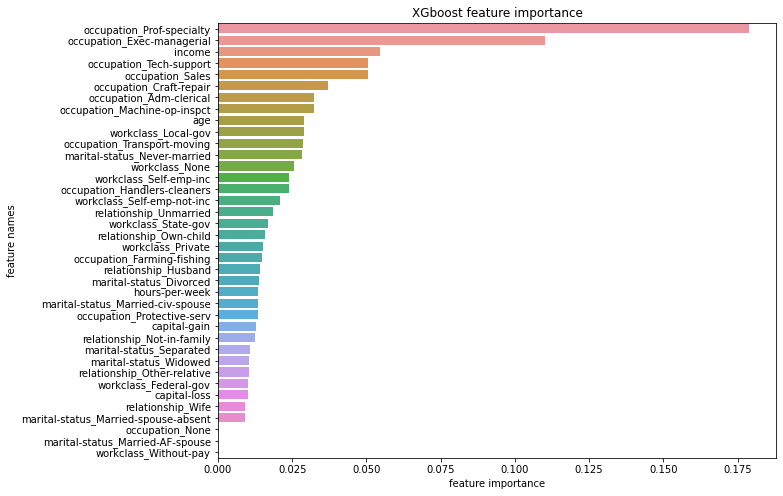

In [56]:
plot_feature_importance(xgb.feature_importances_, X_train.columns, 'XGboost')

In [57]:
X_train.columns

Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'income',
       'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_None',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_None', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'relationship_Husband', 'relationship_Not-in-family',
       'relationship_Ot

In [58]:
xgb.feature_importances_

array([0.02911009, 0.01293533, 0.01001622, 0.01346364, 0.05449927,
       0.01003804, 0.02894605, 0.02558032, 0.01512738, 0.02390403,
       0.02082296, 0.01689692, 0.        , 0.01398401, 0.        ,
       0.01334029, 0.00923465, 0.02813907, 0.01088617, 0.01054839,
       0.03250549, 0.03696651, 0.11006492, 0.01473634, 0.02378887,
       0.03218851, 0.        , 0.17896049, 0.01333411, 0.05050922,
       0.05064295, 0.02868803, 0.01401572, 0.01234785, 0.01043693,
       0.01569035, 0.01839398, 0.00925688], dtype=float32)

#### parameter tuning 모델 성능 비교

In [62]:
print(f'XGBoostClassifier 정확도 : ', accuracy_score(y_test, xgb_pred))
print(f'LightGBMBoostClassifier 정확도 : ', accuracy_score(y_test, lgb_pred))
print(f'CatBoostClassifier 정확도 : ', accuracy_score(y_test, cat_pred))

XGBoostClassifier 정확도 :  0.48732394366197185
LightGBMBoostClassifier 정확도 :  0.4788732394366197
CatBoostClassifier 정확도 :  0.4732394366197183


### VotingClassifier 앙상블 수행

In [ ]:
# Catboost, LightGBM, XGBoost 보팅(소프트)
vo_soft_clf = VotingClassifier( estimators=[('CAT', cat), ('LGB', lgb), ('XGB', xgb)], voting='soft')

# VotingClassifier 학습, 예측, 정확도 계산
vo_soft_clf.fit(X_train, y_train)
soft_pred = vo_soft_clf.predict(X_test)
print('VotingClassifier Soft 정확도: {0:.4f}'.format(accuracy_score(y_test, soft_pred)))

In [61]:
print('VotingClassifier Soft 정확도: {0:.4f}'.format(accuracy_score(y_test, soft_pred)))

VotingClassifier Soft 정확도: 0.4704
